In [1]:
# DCL CNN

# importing all needed functions
import os
from pathlib import Path
from astropy.io import fits
import numpy as np
import glob
import time
from Tools import tools
import traceback
from tqdm import tqdm
import matplotlib.pyplot as plt
from numba import jit
import os
import shutil
import line_profiler
from scipy import stats
from line_profiler import profile
%load_ext line_profiler
import pwkit.bblocks
import sys
import pandas as pd

import warnings

warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", message="Polyfit may be poorly conditioned")


In [22]:
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
import glob
from astropy.io import fits
from numba import jit
import pandas as pd

data_set_path = r"D:\GRB_data\new_dataset"

# directory to save plots to
save_dir = r"C:\Users\arpan\OneDrive\Documents\GRB\Plots"

# Accessing the default color cycle
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def save_to_dir(fig, filename, directory = save_dir, format='pdf', dpi=400, create_dir=False, **kwargs):
    """
    Save a matplotlib figure to a specified directory with error handling.
    
    Parameters:
    -----------
    fig : matplotlib.figure.Figure
        The figure to save
    directory : str
        Directory path where the figure should be saved
    filename : str
        Name of the file (without extension)
    format : str, optional
        File format (e.g., 'png', 'pdf', 'svg', 'jpg')
        Default is 'png'
    dpi : int, optional
        Resolution in dots per inch
        Default is 400
    create_dir : bool, optional
        Whether to create the directory if it doesn't exist
        Default is False
    **kwargs : dict
        Additional arguments passed to plt.savefig()
    
    Returns:
    --------
    str
        Path to the saved file if successful, None if failed
    """
    try:
        # Convert directory to Path object
        dir_path = Path(directory)
        
        # Create directory if it doesn't exist and create_dir is True
        if not dir_path.exists():
            if create_dir:
                dir_path.mkdir(parents=True, exist_ok=True)
            else:
                raise FileNotFoundError(f"Directory {directory} does not exist")
        
        # Ensure filename has the correct extension
        if not filename.endswith(f'.{format}'):
            filename = f'{filename}.{format}'
        
        # Create full file path
        file_path = dir_path / filename
        
        # Save the figure
        fig.savefig(
            file_path,
            format=format,
            dpi=dpi,
            bbox_inches='tight',
            **kwargs
        )
        
        print(f"Figure saved successfully to: {file_path}")
        return str(file_path)
        
    except Exception as e:
        print(f"Error saving figure: {str(e)}")
        return None

@jit(nopython=True)
def filter_counts(times, channels, min_ch, max_ch, trigtime):
    counts = []
    for t, ch in zip(times, channels):
        if min_ch <= ch <= max_ch:
            counts.append(t - trigtime)
    return np.array(counts)

def best_fit_polynomial(x, y, background_intervals):
    # Filter data to include only background intervals
    mask = np.zeros(len(x), dtype=bool)
    for start, end in background_intervals:
        mask |= (x >= start) & (x <= end)
    
    x_bg = x[mask]
    y_bg = y[mask]
    
    best_order = 0
    best_polynomial = None
    best_r_squared = -np.inf
    
    for order in range(1, 5):  # Test polynomials of order 1 to 4
        coeffs = np.polyfit(x_bg, y_bg, order)
        p = np.poly1d(coeffs)
        
        # Calculate R-squared
        y_pred = p(x_bg)
        r_squared = 1 - np.sum((y_bg - y_pred)**2) / np.sum((y_bg - np.mean(y_bg))**2)
        
        # Perform F-test to compare with lower order model
        if order > 1:
            f_statistic = ((r_squared - prev_r_squared) / (order - prev_order)) / \
                          ((1 - r_squared) / (len(x_bg) - order - 1))
            p_value = 1 - stats.f.cdf(f_statistic, 1, len(x_bg) - order - 1)
            
            if p_value < 0.05 and r_squared > best_r_squared:
                best_order = order
                best_polynomial = p
                best_r_squared = r_squared
        else:
            best_order = order
            best_polynomial = p
            best_r_squared = r_squared
        
        prev_order = order
        prev_r_squared = r_squared
    
    return best_polynomial, best_order

def adjust_zeros(arr):
    # Create a copy of the input array
    result = np.copy(arr)
    
    # Find first non-zero element
    first_non_zero = np.argmax(arr != 0)
    
    # Find last non-zero element
    last_non_zero = len(arr) - np.argmax(arr[::-1] != 0) - 1
    
    # Replace value after leading zeros with zero if there are leading zeros
    if first_non_zero > 0:
        result[first_non_zero] = 0
    
    # Replace value before trailing zeros with zero if there are trailing zeros
    if last_non_zero < len(arr) - 1:
        result[last_non_zero] = 0
    
    return result

def hist_plot(hist, edges, label, bkgd = 0, bkgd_pol = 0):
    # Plot histogram
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111)
    
    # Plot the histogram as a step plot
    plt.stairs(hist, edges, fill=False, alpha=0.8, color='cornflowerblue', 
            label='Lightcurve')
    plt.xlabel('Time (s)', fontsize=12)
    plt.ylabel('Counts per second', fontsize=12)
    plt.title(f'{label}', fontsize=14, pad=15)

    # Add grid for better readability
    plt.grid(True, alpha=0.3, linestyle='--')

    # Customize tick labels
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    if bkgd != 0 and bkgd_pol != 0:
        x = (edges[1:] + edges[:-1]) / 2
        # Plot each shaded area
        for i, (x1, x2) in enumerate(bkgd):
            plt.axvspan(x1, x2, alpha=0.3, color='red',label = f'background selection {i+1}') 
        # make sure most things are visible
        plt.gca().set_xlim(left=min(edges))
        plt.gca().set_xlim(right=max(edges))
        plt.gca().set_ylim(bottom = - (max(hist)/20))

        # Evaluate the background polynomial for plotting
        bkgd_y = bkgd_pol(x)
        
        # Check if the background blows up
        if np.any(np.abs(bkgd_y) > 10 * np.max(np.abs(hist))) or np.any(np.abs(bkgd_y) < 0.1 * np.min(np.abs(hist[hist != 0]))):                
            # Plot the background within the limits
            mask = (bkgd_y >= plt.ylim()[0]) & (bkgd_y <= plt.ylim()[1])
            plt.plot(x[mask], bkgd_y[mask], '--', label='background', color = colors[1])
        else:
            # If it doesn't blow up, plot normally
            plt.plot(x, bkgd_y, '--', label='background',color = colors[1])

    plt.axvline(x=0, color='red', linestyle='--', linewidth=0.5, label = 'trigger time')

    # Add legend if you have multiple curves
    plt.legend(fontsize=10, loc = 'best')

    # Adjust layout to prevent label cutoff
    plt.tight_layout()

    return fig

def lc_from_folder(folder, bins, chr, label, style_no = 0):

    # Extract event information from folder name
    event_type, event = folder.split("_")

    # Construct file pattern and find matching files
    file_pattern = str(Path(data_set_path) / folder / 'current' / '*_tte_*')
    NaI_detector = glob.glob(file_pattern)

    print(Path(data_set_path) / folder / 'current')

    # check if the file is processed
    if not (Path(data_set_path) / folder / 'current').exists():
        print('folder does not exist')
        return

    if len(NaI_detector) == 0:
        print(f"No matching files found for {folder}")
        return
        
    # changes to accomodate multiple tte files
    counts_list = []

    for nai in NaI_detector:
        # Read data from FITS file
        with fits.open(nai, memmap=True) as hdul:
            all_count_data = hdul[2].data
            trigtime = float(hdul[2].header['TRIGTIME'])

        # Extract times and channels from all_count_data
        times = all_count_data['TIME'].astype(float)
        channels = all_count_data['PHA'].astype(int)
        
        # Filter counts for different channel ranges
        counts_list.append(filter_counts(times, channels, chr[0], chr[1], trigtime))       

    # putting the counts from different detector into one array
    new_counts_list = []
    
    # Get counts for this energy bin from all detectors and concatenate them
    bin_concat = np.concatenate([counts_list[j] for j in range(0, len(counts_list), 1)])
    new_counts_list.append(bin_concat)

    counts = new_counts_list
            
    # Create histogram
    hist, edges = np.histogram(counts, bins=bins)
    hist = adjust_zeros(hist)
    bin_size = bins[1]-bins[0]
    hrates = hist / bin_size # converting to rates 

    bin_widths = edges[1:]-edges[:-1]

    # Perform Bayesian Block Analysis
    bayes = pwkit.bblocks.bin_bblock(widths = bin_widths, counts = hist, p0 = 0.01)

    # Getting the results of the analysis
    block_starts = (bayes.get('blockstarts') * bin_size) + edges[0]
    block_stops = block_starts + bayes.get('widths')
    bins = np.array(list(block_starts) + list([block_stops[-1]]))
    rates = bayes.get('rates')

    # Find indices where rates are non-zero
    non_zero_indices = np.nonzero(rates)[0]
    
    # Select rates that are non-zero
    rates = rates[non_zero_indices]
    
    try:
        # Select corresponding bins
        bins = np.concatenate([bins[non_zero_indices], [bins[non_zero_indices[-1] + 1]]])
    except:
        bins = [0,0,0,0]
        
    sigw = bins[-2] - bins[1]

    bk2 = bins[1] - (5 * bin_size)
    bk3 = bins[-2] + (5 * bin_size)
    bk1 = bk2 - sigw - (50 * bin_size) if (bk2 - sigw - (50 * bin_size)) > bins[0] else bins[0]
    bk4 = bk3 + sigw + (50 * bin_size) if (bk3 + sigw + (50 * bin_size)) < bins[-1] else bins[-1]
    
    bkgd = [(bk1,bk2),(bk3,bk4)]

    # Check if background is proper
    bkgd_check = bk1<bk2<bk3<bk4

    # Checking for signal
    # Checks False alarm probability p0, number of bins, and if background is detected around trigger
    if bayes.get('finalp0') >= 0.05 or len(bins)<4 or not(bk2 - 5 <= 0 <= bk3 + 5) or not bkgd_check:
        conditions_met = []

        if bayes.get('finalp0') >= 0.05:
            conditions_met.append("bayes.get('finalp0') >= 0.05")
        if len(bins) < 4:
            conditions_met.append("len(bins) < 4")
        if not (bk2 - 5 <= 0 <= bk3 + 5):
            conditions_met.append("not(bk2 - 5 <= 0 <= bk3 + 5)")
        if not bkgd_check:
            conditions_met.append(f"not bkgd_check {bkgd}")

        if conditions_met:
            print("No signal because:")
            for condition in conditions_met:
                print(f"- {condition}")

        print('no signal')
        fig1 = hist_plot(hrates,edges,label)  
        fig2 = None
        fig3 = None
                        
    else:
        y = hrates
        x = (edges[1:] + edges[:-1]) / 2
        bkgd_pol,_ = best_fit_polynomial(x, y, bkgd)
        fig1 = hist_plot(hrates,edges,label, bkgd, bkgd_pol)    

        # Create mask for y between bk2 and bk3
        mask = (x >= bk2) & (x <= bk3)

        # Apply the mask and take the maximum of 0 and y - bkgd_pol(x)
        signal = np.zeros(len(hist)).astype(np.int32)
        signal[mask] = np.maximum(0, (y[mask] - bkgd_pol(x[mask]))).astype(np.int32)

        fig2 = hist_plot(signal,edges,label)
        fig3 = hist_plot(rates,bins,label)

    return fig1,fig2,fig3

                 


index 771
D:\GRB_data\new_dataset\GRB_bn141005217\current


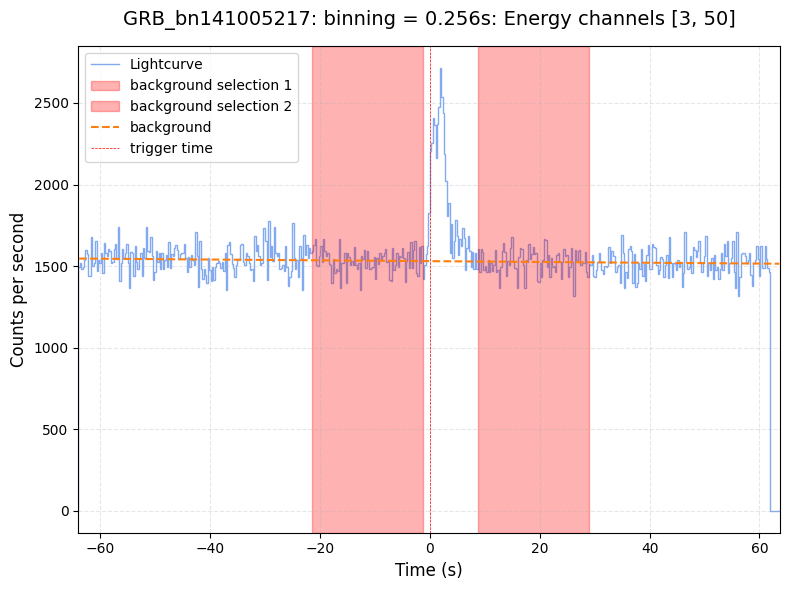

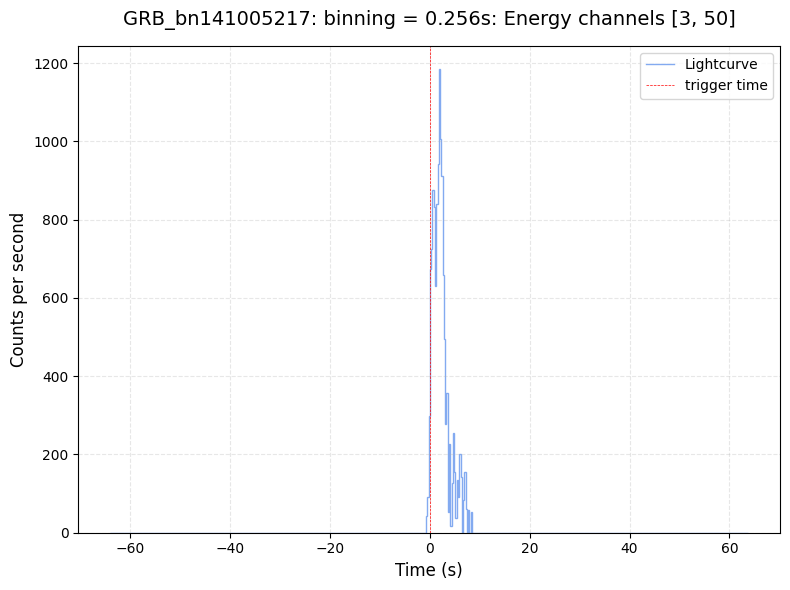

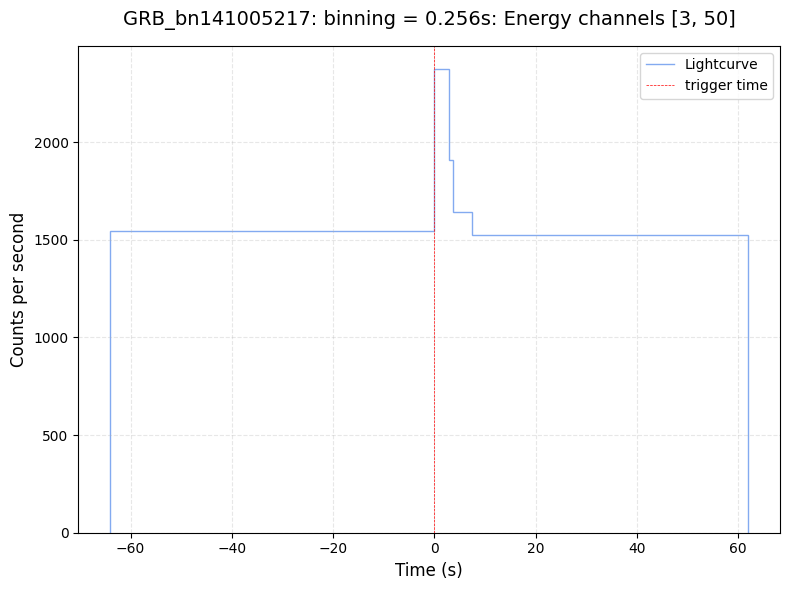

In [ ]:
# importing the events.csv file
df = pd.read_csv('events.csv')
# print(df.head())
N = len(df)

while True:
    i = np.random.randint(0,N)
    # i = 2161
    i = 771
    folder = df.iloc[i]['filename']
    event_type, event = folder.split("_")

    if event_type == 'GRB':
        break

print("index",i)


bin_sizes = [0.001, 0.004, 0.016, 0.064, 0.256, 1.024, 4.096]
data_no = 500
r = 0.5
bin = -3
range_min = -data_no * bin_sizes[bin] * r
range_max = data_no * bin_sizes[bin] * (1-r)
bins = np.arange(range_min,range_max,bin_sizes[bin])


channels = [3, 50] # 10 to 100 keV
# channels = [51,124] # 100 to 900 keV

fig1,fig2,fig3 = lc_from_folder(folder, bins, channels, label=f"{folder}: binning = {bin_sizes[bin]}s: Energy channels {channels}")


plt.show()
save_to_dir(fig, f'{event_type}_example')